### V.A. Логистическая Регрессия: Основы

**Назначение:** Логистическая регрессия — это **линейный метод для задач классификации**. В отличие от линейной регрессии (предсказывающей непрерывные значения), логистическая регрессия предсказывает **вероятность** принадлежности объекта к определенному классу.

**Проблема Линейной Регрессии для Классификации:**
Линейная регрессия ($y = Xw + b$) выдает значения в диапазоне $(-\infty, +\infty)$, что не подходит для вероятностей (требуется диапазон [0, 1]).

**Решение: Сигмоидальная Функция (Sigmoid / Logistic Function):**
Логистическая регрессия использует сигмоиду для "сжатия" выхода линейной комбинации в диапазон [0, 1].

**Как работает (Бинарный случай):**

1.  **Линейная комбинация:** Вычисляется $z = Xw + b$.
2.  **Сигмоида:** $z$ пропускается через сигмоиду:
    $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
3.  **Выход ($\hat{y}$):** Результат $\sigma(z)$ интерпретируется как **вероятность принадлежности к классу "1"** ($\hat{y} = P(y=1|X)$). Вероятность класса "0" равна $1 - \hat{y}$.
4.  **Принятие решения:** Используется порог (обычно 0.5):
    *   Если $\hat{y} \ge 0.5$, предсказывается класс "1".
    *   Если $\hat{y} < 0.5$, предсказывается класс "0".

**Свойства Сигмоиды:**

*   **Диапазон:** [0, 1].
*   **Форма:** S-образная кривая (значение 0.5 при z=0, стремится к 1 при $z \to +\infty$, к 0 при $z \to -\infty$).
*   **Дифференцируемость:** Важно для градиентного спуска. Производная: $\sigma'(z) = \sigma(z) (1 - \sigma(z))$.

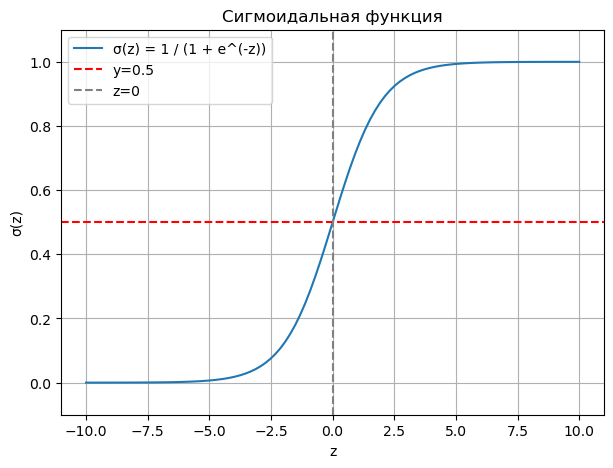

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- Сигмоидальная функция ---
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# --- Визуализация Сигмоиды ---
z_vals = np.linspace(-10, 10, 100)
sigmoid_vals = sigmoid(z_vals)

plt.figure(figsize=(7, 5))
plt.plot(z_vals, sigmoid_vals, label="σ(z) = 1 / (1 + e^(-z))")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.title("Сигмоидальная функция")
plt.grid(True)
plt.ylim(-0.1, 1.1) # Немного расширим диапазон Y для наглядности
plt.axhline(y=0.5, color='red', linestyle='--', label='y=0.5') # Горизонталь на 0.5
plt.axvline(x=0, color='gray', linestyle='--', label='z=0') # Вертикаль на 0
plt.legend()
plt.show()

---

### V.B. Функция Потерь: Log Loss (Бинарная Кросс-Энтропия)

**Проблема MSE для Классификации:** MSE плохо подходит для вероятностей (не учитывает диапазон [0, 1], невыпуклость функции потерь при использовании с сигмоидой).

**Log Loss (Binary Cross-Entropy):** Стандартная функция потерь для бинарной классификации, измеряющая ошибку предсказания вероятностей.

**Формула (для одного объекта):**
$$L(y, \hat{y}) = - [y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})]$$
*   `y`: Истинный класс (0 или 1).
*   `ŷ`: Предсказанная вероятность класса 1.
*   `log()`: Натуральный логарифм.

**Интерпретация:**
*   Если `y=1`, $L = -\log(\hat{y})$. Штраф растет, когда $\hat{y} \to 0$.
*   Если `y=0`, $L = -\log(1-\hat{y})$. Штраф растет, когда $\hat{y} \to 1$.
*   Штрафует модель за "уверенные" неправильные предсказания сильнее, чем за "неуверенные".

**Средний Log Loss (по всем N объектам):**
$$J(w, b) = - \frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]$$
Именно эту функцию $J(w, b)$ мы минимизируем при обучении.

In [32]:
# --- Функция Log Loss ---
def calculate_log_loss(y_true, y_predicted_proba):
  epsilon = 1e-15 # Для численной стабильности (избегаем log(0))
  y_predicted_proba = np.clip(y_predicted_proba, epsilon, 1 - epsilon)
  log_loss = - np.mean(y_true * np.log(y_predicted_proba) + (1 - y_true) * np.log(1 - y_predicted_proba))
  return log_loss

# --- Пример использования ---
y_true_example = np.array([1, 0, 1, 0, 1])
y_predicted_proba_example = np.array([0.9, 0.1, 0.8, 0.3, 0.7])
log_loss_example = calculate_log_loss(y_true_example, y_predicted_proba_example)
# print(f"Пример Log Loss = {log_loss_example:.4f}") # Около 0.1935

---

### V.C. Обучение: Градиентный Спуск для Log Loss

**Цель:** Найти оптимальные `w` и `b`, минимизирующие средний Log Loss $J(w, b)$.

**Градиенты Log Loss:** (Удивительно похожи на градиенты MSE для линейной регрессии!)

*   **По весам `w`:**
    $$\frac{\partial J}{\partial w} = \frac{1}{N} X^T (\hat{y} - y)$$
    (где $\hat{y} = \sigma(Xw+b)$)
*   **По смещению `b`:**
    $$\frac{\partial J}{\partial b} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i) = \text{mean}(\hat{y} - y)$$

**Алгоритм Градиентного Спуска:**

1.  Инициализировать `w` и `b` (нулями или малыми случайными числами).
2.  Повторять `num_iterations` раз:
    *   Вычислить предсказанные вероятности: $\hat{y} = \sigma(Xw + b)$.
    *   Вычислить градиенты $\frac{\partial J}{\partial w}$ и $\frac{\partial J}{\partial b}$.
    *   Обновить параметры:
        $w := w - \eta \frac{\partial J}{\partial w}$
        $b := b - \eta \frac{\partial J}{\partial b}$
        (где $\eta$ - `learning_rate`).

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification # Функция для генерации данных классификации
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression # Импортируем LogisticRegression из scikit-learn и переименовываем
from sklearn.metrics import log_loss as sklearn_log_loss # Импортируем log_loss из scikit-learn для сравнения
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# --- 1. Генерируем синтетические данные для бинарной классификации ---
num_samples = 100
num_features = 2 # Для наглядности сделаем 2 признака
np.random.seed(42)

X_classification, y_classification = make_classification(
    n_samples=num_samples,
    n_features=num_features,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=42
)
# Преобразуем y_classification в вектор-столбец для консистентности в расчетах
y_classification = y_classification.reshape(-1, 1)

Итерация 100/1000: Log Loss = 0.1704
Итерация 200/1000: Log Loss = 0.1199
Итерация 300/1000: Log Loss = 0.0990
Итерация 400/1000: Log Loss = 0.0870
Итерация 500/1000: Log Loss = 0.0791
Итерация 600/1000: Log Loss = 0.0733
Итерация 700/1000: Log Loss = 0.0689
Итерация 800/1000: Log Loss = 0.0655
Итерация 900/1000: Log Loss = 0.0626
Итерация 1000/1000: Log Loss = 0.0602

Обучение своей реализации завершено!
Финальные параметры: w = [ 4.50196856 -1.3033994 ], b = 0.0914
Финальное значение Log Loss: 0.0602


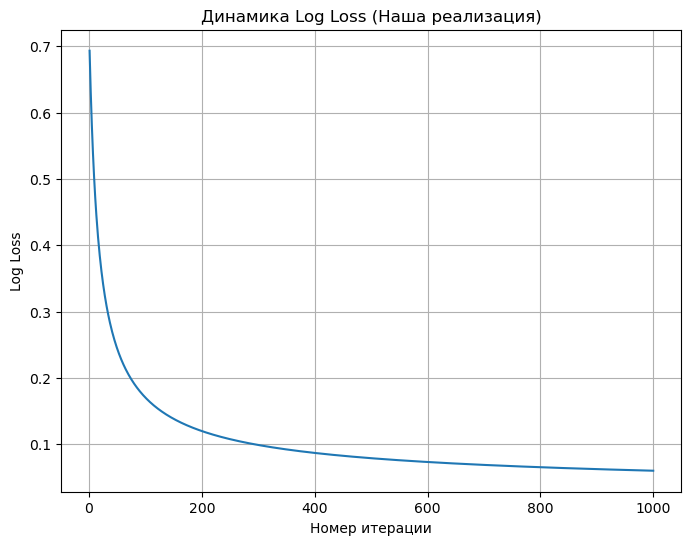

In [34]:
# --- 2. Реализация Сигмоидальной функции ---
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# --- 3. Реализация Функции Log Loss ---
def calculate_log_loss(y_true, y_predicted_proba):
  epsilon = 1e-15
  y_predicted_proba = np.clip(y_predicted_proba, epsilon, 1 - epsilon)
  log_loss = - np.mean(y_true * np.log(y_predicted_proba) + (1 - y_true) * np.log(1 - y_predicted_proba))
  return log_loss

# --- 4. Функции градиентов Log Loss ---
def calculate_gradient_log_loss_w(X, y_true, y_predicted_proba):
  errors = y_predicted_proba - y_true # y_true уже (m, 1), y_predicted_proba (m, 1) -> errors (m, 1)
  gradient_w = (1 / len(y_true)) * np.dot(X.T, errors) # X.T (n, m) @ errors (m, 1) -> gradient_w (n, 1)
  return gradient_w

def calculate_gradient_log_loss_b(y_true, y_predicted_proba):
  errors = y_predicted_proba - y_true
  gradient_b = np.mean(errors) # Среднее по (m, 1) -> скаляр
  return gradient_b

# --- 5. Реализация алгоритма градиентного спуска ---
# Гиперпараметры
learning_rate = 0.1 # Можно попробовать чуть больше чем 0.01
num_iterations = 1000

# Инициализация параметров
w_logistic = np.zeros((num_features, 1)) # (n, 1)
b_logistic = 0                           # Скаляр

# История Log Loss
log_loss_history = []

# Цикл градиентного спуска
for iteration in range(num_iterations):
  # 1. Предсказание вероятностей
  z = np.dot(X_classification, w_logistic) + b_logistic # X (m, n) @ w (n, 1) -> (m, 1); + b (скаляр) -> z (m, 1)
  y_predicted_proba_logistic = sigmoid(z)               # sigmoid(z (m, 1)) -> y_pred (m, 1)

  # 2. Расчет Log Loss
  log_loss = calculate_log_loss(y_classification, y_predicted_proba_logistic)
  log_loss_history.append(log_loss)

  # 3. Расчет градиентов
  gradient_w_logistic = calculate_gradient_log_loss_w(X_classification, y_classification, y_predicted_proba_logistic) # -> (n, 1)
  gradient_b_logistic = calculate_gradient_log_loss_b(y_classification, y_predicted_proba_logistic) # -> скаляр

  # 4. Обновление параметров
  w_logistic = w_logistic - learning_rate * gradient_w_logistic # w (n, 1) - scalar * grad_w (n, 1)
  b_logistic = b_logistic - learning_rate * gradient_b_logistic # b (scalar) - scalar * grad_b (scalar)

  # Вывод прогресса
  if (iteration + 1) % 100 == 0:
    print(f"Итерация {iteration + 1}/{num_iterations}: Log Loss = {log_loss:.4f}") # Убрали вывод w, b для краткости

print("\nОбучение своей реализации завершено!")
print(f"Финальные параметры: w = {w_logistic.flatten()}, b = {b_logistic:.4f}")
print(f"Финальное значение Log Loss: {log_loss_history[-1]:.4f}")

# --- 6. Визуализация процесса обучения (график Log Loss) ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_iterations + 1), log_loss_history) # Убрали маркеры для гладкости
plt.xlabel("Номер итерации")
plt.ylabel("Log Loss")
plt.title("Динамика Log Loss (Наша реализация)")
plt.grid(True)
plt.show()
plt.close()

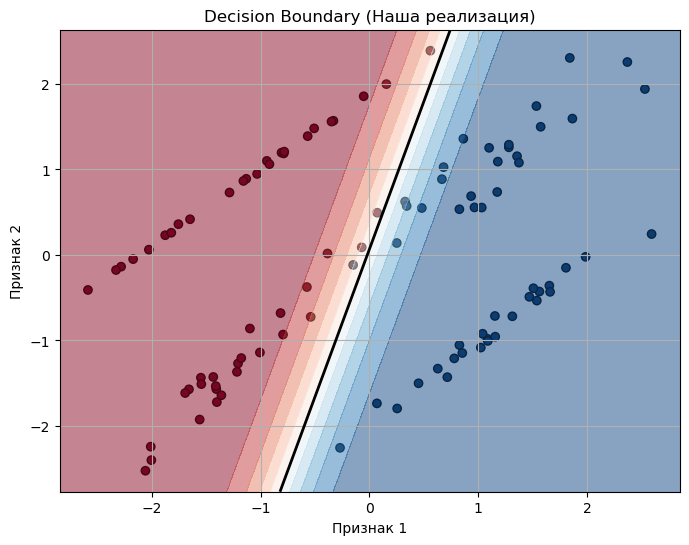

In [35]:
# --- 7. Визуализация разделяющей границы (Decision Boundary) ---
def predict_class(y_proba):
    # Убедимся что на входе 1D массив или вектор-столбец
    y_proba_flat = np.asarray(y_proba).ravel()
    return np.where(y_proba_flat >= 0.5, 1, 0)

plt.figure(figsize=(8, 6))
# Рисуем исходные точки
plt.scatter(X_classification[:, 0], X_classification[:, 1], c=y_classification.ravel(), cmap=plt.cm.RdBu, edgecolors='k', label='Данные')

# Создаем сетку
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
X_grid = np.c_[xx.ravel(), yy.ravel()] # Форма (10000, 2)

# Предсказываем вероятности на сетке нашей моделью
z_grid = np.dot(X_grid, w_logistic) + b_logistic # (10000, 2) @ (2, 1) -> (10000, 1)
proba_grid = sigmoid(z_grid).reshape(xx.shape)    # sigmoid -> (10000, 1), reshape -> (100, 100)

# Рисуем заливку областей и границу
plt.contourf(xx, yy, proba_grid, levels=np.linspace(0, 1, 11), cmap=plt.cm.RdBu, alpha=0.5) # Уменьшил levels для четкости
contour_line = plt.contour(xx, yy, proba_grid, levels=[0.5], colors='black', linewidths=2) # Сделал линию жирнее

plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.title("Decision Boundary (Наша реализация)")
# plt.legend() # Легенда здесь не очень нужна
plt.grid(True)
plt.show()
plt.close()


Accuracy нашей реализации на обучающей выборке: 0.9900

--- Сравнение с scikit-learn ---

Сравнение параметров:
Наши параметры:      w = [ 4.50196856 -1.3033994 ], b = 0.0914
Параметры sklearn:   w = [ 3.2318 -0.8452], b = 0.0438

Сравнение Log Loss:
Наш Log Loss:        0.0602
Log Loss sklearn:    0.0905

Сравнение Accuracy:
Наша Accuracy:       0.9900
Accuracy sklearn:    0.9900


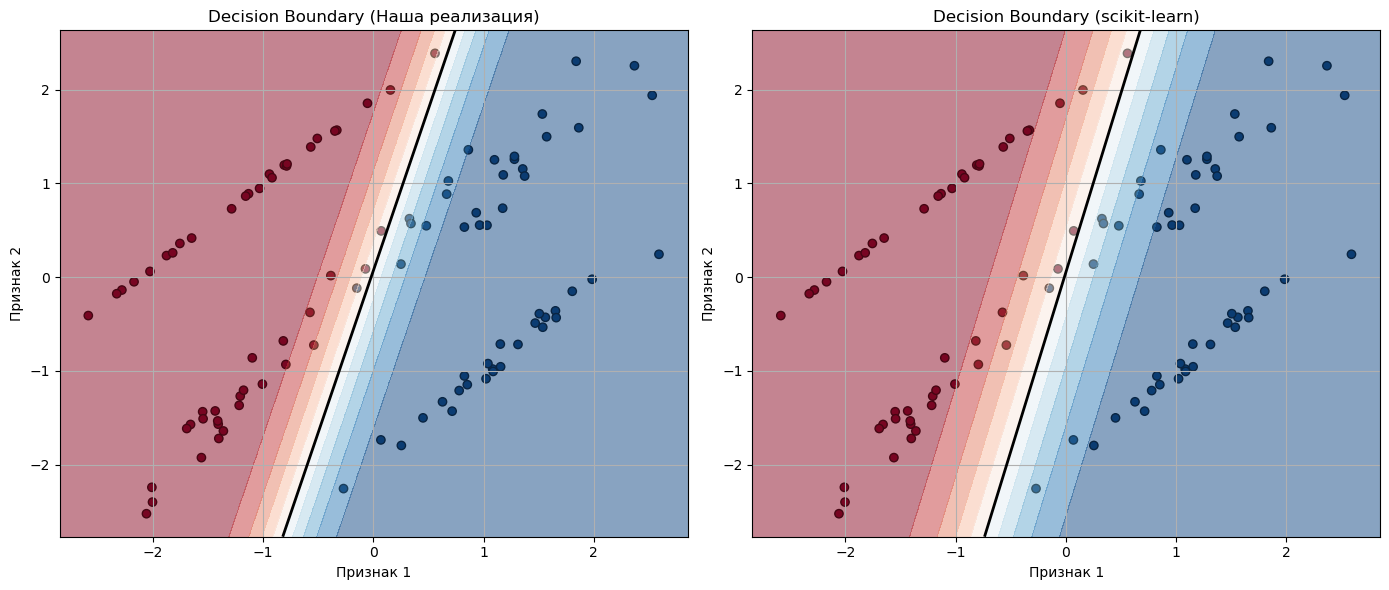

In [36]:

# --- 8. Оценка Accuracy ---
# Предсказываем вероятности на обучающих данных
y_predicted_proba_train = sigmoid(np.dot(X_classification, w_logistic) + b_logistic)
# Преобразуем вероятности в классы
y_train_predicted_class = predict_class(y_predicted_proba_train)
# Вычисляем Accuracy
accuracy_train = accuracy_score(y_classification.ravel(), y_train_predicted_class) # y_classification нужно сделать 1D

print(f"\nAccuracy нашей реализации на обучающей выборке: {accuracy_train:.4f}")


# --- 9. Сравнение с sklearn.linear_model.LogisticRegression ---
print("\n--- Сравнение с scikit-learn ---")

# a) Обучение sklearn модели
model_sklearn = SklearnLogisticRegression(solver='liblinear', random_state=42) # Выберем solver
model_sklearn.fit(X_classification, y_classification.ravel()) # sklearn ожидает y как 1D массив

# b) Сравнение параметров
sklearn_w_comparison = model_sklearn.coef_[0] # (n,)
sklearn_b_comparison = model_sklearn.intercept_[0] # скаляр
print("\nСравнение параметров:")
print(f"Наши параметры:      w = {w_logistic.flatten()}, b = {b_logistic:.4f}")
print(f"Параметры sklearn:   w = {np.round(sklearn_w_comparison, 4)}, b = {sklearn_b_comparison:.4f}")
# Могут немного отличаться из-за разных солверов и регуляризации по умолчанию в sklearn

# c) Сравнение Log Loss
y_predicted_proba_sklearn = model_sklearn.predict_proba(X_classification)[:, 1] # Вероятности класса 1
sklearn_log_loss_comparison = sklearn_log_loss(y_classification.ravel(), y_predicted_proba_sklearn)
print("\nСравнение Log Loss:")
print(f"Наш Log Loss:        {log_loss_history[-1]:.4f}")
print(f"Log Loss sklearn:    {sklearn_log_loss_comparison:.4f}")

# d) Сравнение Accuracy
y_train_predicted_class_sklearn = model_sklearn.predict(X_classification)
accuracy_train_sklearn = accuracy_score(y_classification.ravel(), y_train_predicted_class_sklearn)
print("\nСравнение Accuracy:")
print(f"Наша Accuracy:       {accuracy_train:.4f}")
print(f"Accuracy sklearn:    {accuracy_train_sklearn:.4f}")

# e) Визуализация Decision Boundaries рядом
plt.figure(figsize=(14, 6))

# Subplot 1: Наша реализация
plt.subplot(1, 2, 1)
plt.scatter(X_classification[:, 0], X_classification[:, 1], c=y_classification.ravel(), cmap=plt.cm.RdBu, edgecolors='k')
plt.contourf(xx, yy, proba_grid, levels=np.linspace(0, 1, 11), cmap=plt.cm.RdBu, alpha=0.5)
plt.contour(xx, yy, proba_grid, levels=[0.5], colors='black', linewidths=2)
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.title("Decision Boundary (Наша реализация)")
plt.grid(True)

# Subplot 2: scikit-learn
plt.subplot(1, 2, 2)
plt.scatter(X_classification[:, 0], X_classification[:, 1], c=y_classification.ravel(), cmap=plt.cm.RdBu, edgecolors='k')
# Предсказываем вероятности sklearn на сетке
proba_grid_sklearn = model_sklearn.predict_proba(X_grid)[:, 1].reshape(xx.shape)
plt.contourf(xx, yy, proba_grid_sklearn, levels=np.linspace(0, 1, 11), cmap=plt.cm.RdBu, alpha=0.5)
plt.contour(xx, yy, proba_grid_sklearn, levels=[0.5], colors='black', linewidths=2)
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.title("Decision Boundary (scikit-learn)")
plt.grid(True)

plt.tight_layout()
plt.show()

---

### V.D. Мультиклассовая Логистическая Регрессия

**Проблема:** Бинарная логистическая регрессия работает только для двух классов.

**Решение:** Расширение на K > 2 классов с использованием функции **Softmax**.

**Функция Softmax:**
Преобразует вектор "скоров" (сырых выходов модели) $z = [z_1, ..., z_K]$ в вектор вероятностей $\hat{y} = [\hat{y}_1, ..., \hat{y}_K]$, где $\sum \hat{y}_i = 1$ и $\hat{y}_i \in [0, 1]$.

**Формула:**
$$\text{softmax}(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$
*   Экспоненты делают скоры положительными и усиливают различия.
*   Деление на сумму экспонент нормализует результат в вероятности.

**Как работает мультиклассовая логистическая регрессия:**

1.  **Линейные комбинации:** Для *каждого класса* $k$ вычисляется свой скор:
    $z_k = X w_k + b_k$
    (Теперь есть матрица весов $W$ размера `(K, n)` и вектор смещений $b$ размера `(K,)`).
2.  **Softmax:** Вектор скоров $z = [z_1, ..., z_K]$ пропускается через Softmax для получения вектора вероятностей $\hat{y} = \text{softmax}(z)$.
3.  **Предсказание:** Выбирается класс с максимальной вероятностью: $\text{argmax}_k(\hat{y}_k)$.

**Функция Потерь: Категориальная Кросс-Энтропия**
Обобщение Log Loss на K классов.

**Формула (для одного объекта с one-hot вектором `y`):**
$$L(y, \hat{y}) = - \sum_{i=1}^{K} y_i \log(\hat{y}_i)$$
*   `y = [y_1, ..., y_K]`: One-hot вектор истинного класса (1 для истинного класса, 0 для остальных).
*   $\hat{y} = [\hat{y}_1, ..., \hat{y}_K]$: Вектор предсказанных вероятностей (выход Softmax).

**Упрощение (если $c$ - индекс истинного класса):**
$$L = - \log(\hat{y}_c)$$
Минимизация этой функции заставляет модель максимизировать вероятность истинного класса.

**Средняя Категориальная Кросс-Энтропия (по N объектам):**
$$J(W, b) = - \frac{1}{N} \sum_{j=1}^{N} \sum_{i=1}^{K} y_{ij} \log(\hat{y}_{ij})$$

**Обучение:** Обычно используется готовая реализация (например, `sklearn.linear_model.LogisticRegression` с параметром `multi_class='multinomial'`). Алгоритмы оптимизации (например, `lbfgs`) минимизируют категориальную кросс-энтропию для нахождения оптимальных матриц $W$ и векторов $b$.

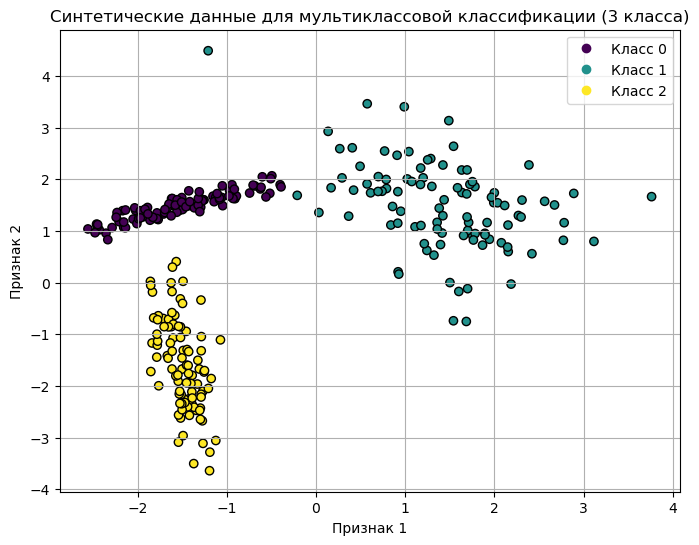

Матрица признаков X_multiclass (первые 5 строк):
 [[ 1.94376956  0.83838381]
 [-1.47372858 -1.65643418]
 [-1.3084432  -1.67345151]
 [-1.48852958 -1.3140137 ]
 [-1.50194335 -1.67539771]]
Вектор целевой переменной y_multiclass (первые 5 элементов):
 [1 2 2 2 2]
------------------------------


In [37]:
# --- 1. Генерируем синтетические данные для мультиклассовой классификации ---
num_samples_multiclass = 300 # Увеличим количество точек для наглядности
num_features = 2 # Оставим 2 признака для визуализации
num_classes = 3 # Теперь 3 класса!
np.random.seed(42)

# Используем make_classification с n_classes=3
X_multiclass, y_multiclass = make_classification(
    n_samples=num_samples_multiclass,
    n_features=num_features,
    n_informative=2, # Оба признака будут информативными
    n_redundant=0,
    n_repeated=0,
    n_classes=num_classes,
    n_clusters_per_class=1, # По одному кластеру на класс для лучшей разделимости
    class_sep=1.5, # Увеличим разделение между классами
    random_state=42
)

# Визуализируем данные мультиклассовой классификации
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_multiclass[:, 0], X_multiclass[:, 1], c=y_multiclass, cmap=plt.cm.viridis, edgecolors='k')
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.title("Синтетические данные для мультиклассовой классификации (3 класса)")
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Класс {i}' for i in range(num_classes)])
plt.grid(True)
plt.show()
plt.close()

print("Матрица признаков X_multiclass (первые 5 строк):\n", X_multiclass[:5])
print("Вектор целевой переменной y_multiclass (первые 5 элементов):\n", y_multiclass[:5])
print("-" * 30)

In [38]:
# --- 2. Обучение LogisticRegression для мультиклассовой классификации ---
# Используем multi_class='multinomial' для Softmax и Categorical Cross-Entropy
# solver='lbfgs' хорошо подходит для multinomial
model_sklearn_multiclass = SklearnLogisticRegression(solver='lbfgs', random_state=42)
model_sklearn_multiclass.fit(X_multiclass, y_multiclass) # Обучаем модель

# --- Получение параметров модели (опционально, для информации) ---
sklearn_w_multiclass = model_sklearn_multiclass.coef_ # Веса (матрица 3x2)
sklearn_b_multiclass = model_sklearn_multiclass.intercept_ # Смещения (вектор 3,)

print("\n--- Мультиклассовая LogisticRegression (sklearn) обучена ---")
# print(f"Параметры w (веса признаков):\n{sklearn_w_multiclass}")
# print(f"Параметры b (смещения): {sklearn_b_multiclass}")
# print("-" * 30)


--- Мультиклассовая LogisticRegression (sklearn) обучена ---


In [39]:
# --- 3. Предсказание классов и вероятностей ---

# a) Предсказание вероятностей классов
y_predicted_proba_multiclass_sklearn = model_sklearn_multiclass.predict_proba(X_multiclass)

print("\n--- Предсказанные вероятности (первые 5 объектов) ---")
# Выводим вероятности для каждого класса для первых 5 объектов
# Каждая строка суммируется в 1
print(np.round(y_predicted_proba_multiclass_sklearn[:5], 3))

# b) Предсказание классов (выбор класса с наибольшей вероятностью)
y_predicted_class_multiclass_sklearn = model_sklearn_multiclass.predict(X_multiclass)

print("\n--- Предсказанные классы (первые 5 объектов) ---")
print(y_predicted_class_multiclass_sklearn[:5])
print("-" * 30)


--- Предсказанные вероятности (первые 5 объектов) ---
[[0.    1.    0.   ]
 [0.001 0.    0.999]
 [0.001 0.    0.999]
 [0.002 0.    0.998]
 [0.001 0.    0.999]]

--- Предсказанные классы (первые 5 объектов) ---
[1 2 2 2 2]
------------------------------



--- Accuracy на обучающей выборке (мультикласс) ---
Accuracy scikit-learn (мультикласс): 0.9933


<Figure size 800x600 with 0 Axes>

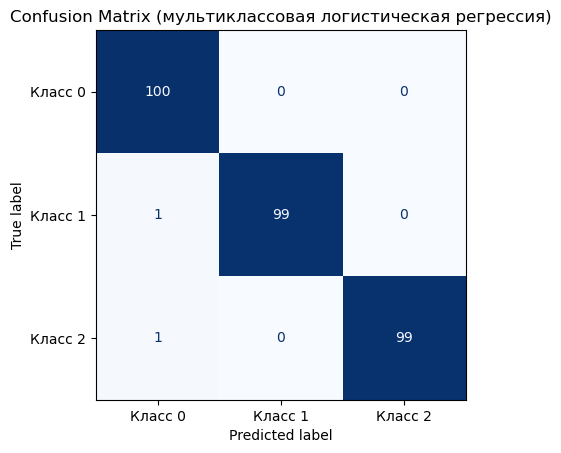

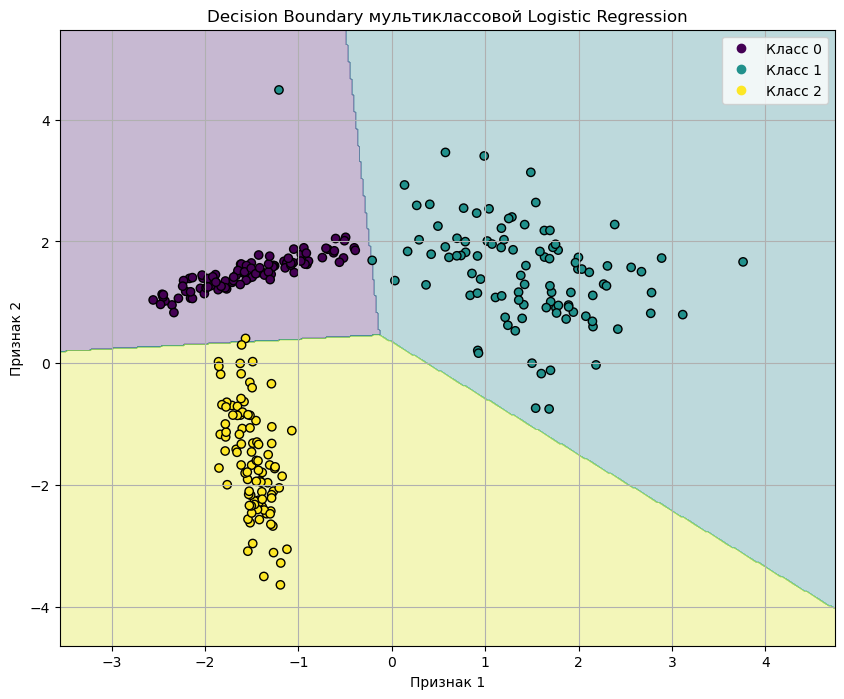

In [40]:
# --- 4. Оценка качества: Accuracy и Confusion Matrix ---

# a) Вычисление Accuracy
accuracy_multiclass = accuracy_score(y_multiclass, y_predicted_class_multiclass_sklearn)

print(f"\n--- Accuracy на обучающей выборке (мультикласс) ---")
print(f"Accuracy scikit-learn (мультикласс): {accuracy_multiclass:.4f}")

# b) Вычисление и визуализация Confusion Matrix
cm_multiclass = confusion_matrix(y_multiclass, y_predicted_class_multiclass_sklearn)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multiclass,
                              display_labels=[f"Класс {i}" for i in range(num_classes)])
disp.plot(cmap=plt.cm.Blues, colorbar=False) # Добавили colorbar=False для чистоты
plt.title("Confusion Matrix (мультиклассовая логистическая регрессия)")
plt.show()
plt.close()

# Дополнительно: Визуализация разделяющих границ для мультикласса
plt.figure(figsize=(10, 8))

# Создаем сетку для построения областей
x_min, x_max = X_multiclass[:, 0].min() - 1, X_multiclass[:, 0].max() + 1
y_min, y_max = X_multiclass[:, 1].min() - 1, X_multiclass[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Предсказываем классы для каждой точки сетки
Z = model_sklearn_multiclass.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Рисуем области классов
plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.3)

# Рисуем исходные точки
scatter = plt.scatter(X_multiclass[:, 0], X_multiclass[:, 1], c=y_multiclass, cmap=plt.cm.viridis, edgecolors='k')

plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Decision Boundary мультиклассовой Logistic Regression')
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Класс {i}' for i in range(num_classes)])
plt.grid(True)
plt.show()

---